In [9]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import open3d as o3d
from pathlib import Path
import pandas as pd
import segment
from scipy import ndimage as ndi
from skimage import color, feature, filters, morphology, measure, segmentation, util
from stl import mesh
import sys
import yaml
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in Images

Key "Number of Pre-Surface Meshing Erosions" not found. Setting ui["n_erosions"] to None.
Key "Smooth Voxels with Median Filtering" not found. Setting ui["post_seg_med_filter"] to None.
Key "Number of Smoothing Iterations" not found. Setting ui["mesh_smooth_n_iters"] to None.
Key "Target number of Triangles/Faces" not found. Setting ui["mesh_simplify_n_tris"] to None.
Key "Simplification factor Per Iteration" not found. Setting ui["mesh_simplify_factor"] to None.
Loading images...
--> Images loaded as 3D array:  (80, 100, 100)
--> Size of array (GB):  0.0016
Plotting images: [0, 20, 40, 60]


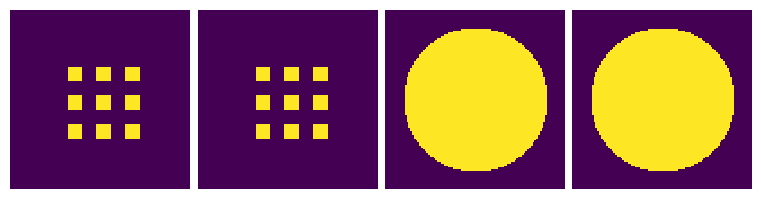

In [10]:
# Read YAML input file
ui = segment.load_inputs(Path('segment_cake_0001.yml'))
# Load images
print('Loading images...')
imgs = segment.load_images(
    ui['ct_img_dir'],
    slice_crop=ui['slice_crop'],
    row_crop=ui['row_crop'],
    col_crop=ui['col_crop'],
    convert_to_float=True,
    file_suffix=ui['file_suffix']
)
print('--> Images loaded as 3D array: ', imgs.shape)
print('--> Size of array (GB): ', imgs.nbytes / 1E9)
# Plot images
fig, axes = segment.plot_imgs(imgs, n_imgs=4)
plt.show()

## Add preprocessing step

### Median filter followed by intensity rescale

Preprocessing images...
--> Preprocessing complete
--> Size of array (GB):  0.0016
Plotting images: [0, 20, 40, 60]


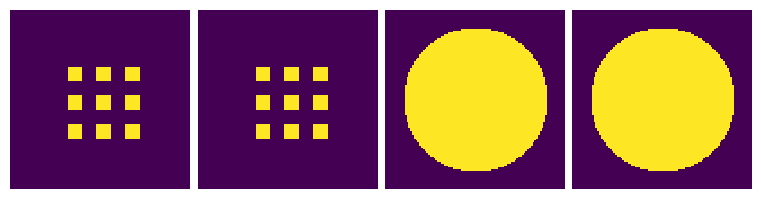

In [11]:
print('Preprocessing images...')
imgs_pre = segment.preprocess(
    imgs, 
    median_filter=ui['pre_seg_med_filter'], 
    rescale_intensity_range=ui['rescale_range']
)
print('--> Preprocessing complete')
print('--> Size of array (GB): ', imgs_pre.nbytes / 1E9)
# Plot preprocessed images
fig, axes = segment.plot_imgs(imgs_pre, n_imgs=4)
plt.show()

Binarizing images...
Calculating Otsu threshold(s)...
--> Binarization complete
--> Size of array (GB):  0.0008
Plotting images: [0, 20, 40, 60]


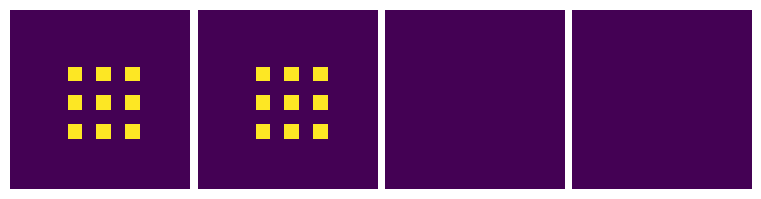

In [12]:
print('Binarizing images...')
# Borders must be excluded after seg. to avoid exclusion of connected regions
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
    imgs_pre, 
    n_otsu_classes=ui['n_otsu_classes'], 
    n_selected_thresholds=ui['n_selected_classes'], 
    exclude_borders=False, 
)
print('--> Binarization complete')
print('--> Size of array (GB): ', imgs_binarized.nbytes / 1E9)
# Plot binarized images
fig, axes = segment.plot_imgs(imgs_binarized, n_imgs=4)
plt.show()

## Segment the Images

Segmenting images...
--> Segmentation complete
--> Total number of particles segmented: 45
Plotting images: [0, 26, 52]


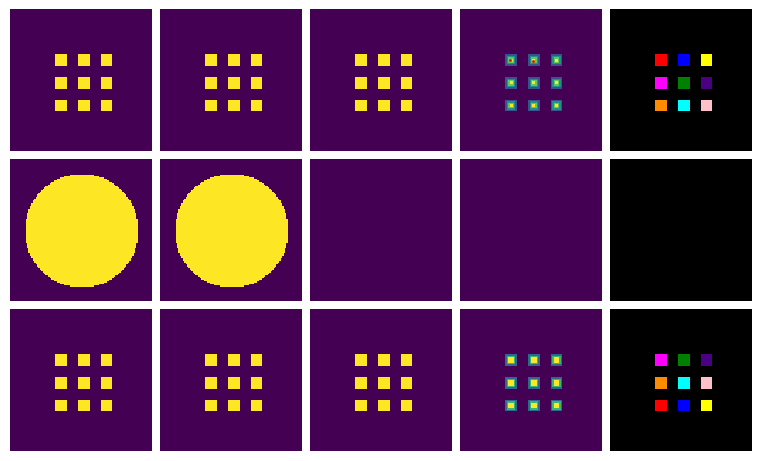

In [13]:
print('Segmenting images...')
segment_dict = segment.watershed_segment(
    imgs_binarized, min_peak_distance=ui['min_peak_dist'], 
    use_int_dist_map=ui['use_int_dist_map'], return_dict=True
)
print('--> Segmentation complete')
# How Many Particles Were Segmented?
n_particles = np.max(segment_dict['integer-labels'])
n_particles_digits = len(str(n_particles))
print('--> Total number of particles segmented: ' + str(n_particles))
# Plot segmentation results
fig, axes = segment.plot_segment_steps(
    imgs, imgs_pre, imgs_binarized, segment_dict
)
plt.show()

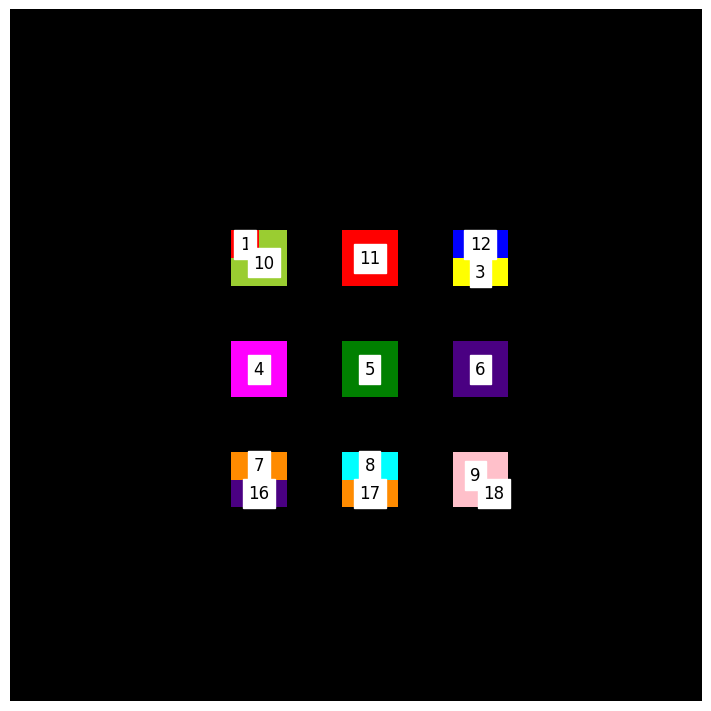

In [14]:
fig, ax = segment.plot_particle_labels(
    segment_dict, 2, label_color='black', label_bg_color='white'
)

In [33]:
img_test = imgs[0, :, :]
print(img_test.shape)
labels_test = measure.label(img_test)
regions_test = measure.regionprops(labels_test)
regions_test = sorted(regions_test, key=lambda x: x.area)
print(regions_test[1].area)
print(regions_test[-1].area)

(100, 100)
64
4437


### Exclude border particles

--> Number of particles before border exclusion:  45

Excluding border particles...
--> Number of particles:  36
Plotting images: [0, 26, 52]


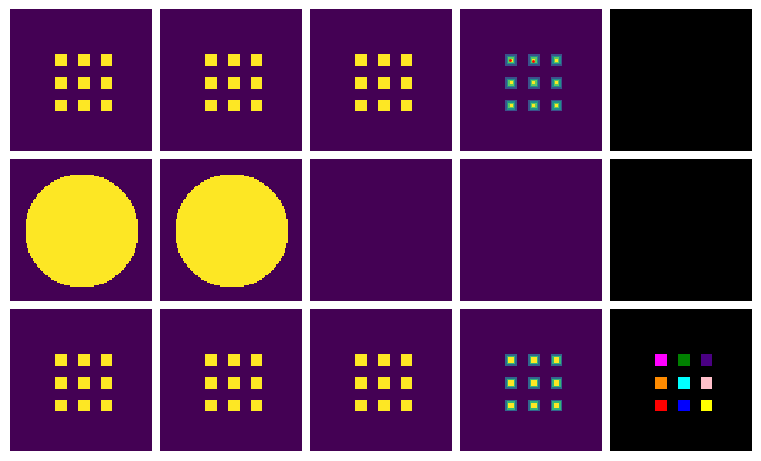

In [15]:
if ui['exclude_borders']:
    # How Many Particles Were Segmented?
    n_particles = np.max(segment_dict['integer-labels'])
    n_particles_digits = len(str(n_particles))
    print('--> Number of particles before border exclusion: ', str(n_particles))
    print()
    print('Excluding border particles...')
    segment_dict['integer-labels'] = segmentation.clear_border(
        segment_dict['integer-labels']
    )
regions = measure.regionprops(segment_dict['integer-labels'])
n_particles_noborder = len(regions)
print('--> Number of particles: ', str(n_particles_noborder))
fig, axes = segment.plot_segment_steps(imgs, imgs_pre, imgs_binarized, segment_dict)
plt.show()

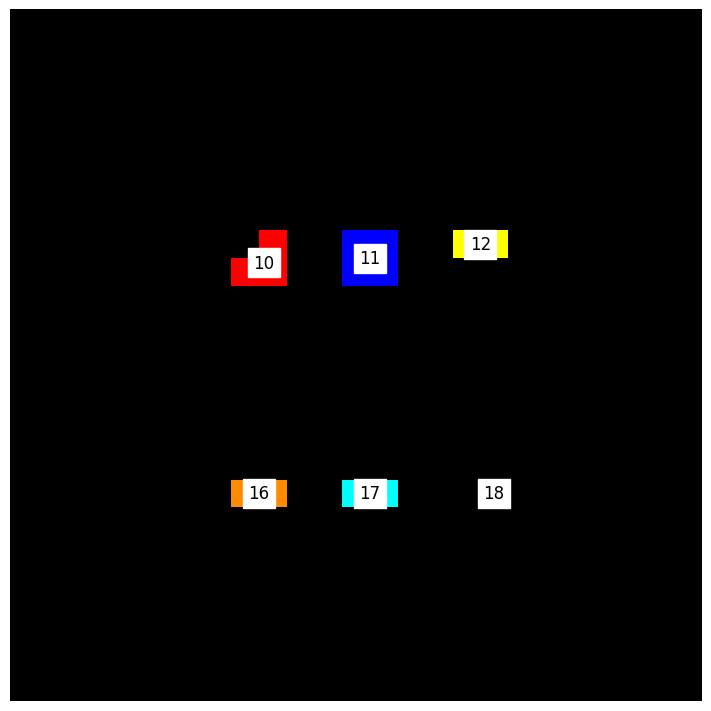

In [16]:
fig, ax = segment.plot_particle_labels(
    segment_dict, 2, label_color='black', label_bg_color='white'
)